In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score

from sklearn.metrics import precision_recall_fscore_support


import pickle

import json




In [17]:
from json import JSONEncoder
import json
import numpy

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

# Model functions

In [18]:

def data_preprocess(data):
  '''We input the data with the linguistic features
  And it returns the data with the polarity columns in 0 for fake and 1 for true
  as well as the outcomes
  '''

  if data["Polarity"][0] != 0 or 1:
    data["Polarity"] = data["Polarity"].replace("Fake", 0)
    data["Polarity"] = data["Polarity"].replace("TRUE", 1)

  outcomes = ["Fake","Real"]
  
  return data, outcomes

def test_train(data, features):

  '''We input the data with the features and a list of the features we want to pass to the models.
  it returns the data split in test/train
  '''

  feature_cols = features
  data = data[feature_cols + ["Polarity"]].dropna()

  X = data[feature_cols]
  y = data["Polarity"] #outcomes 0 or 1


  print("Info: {} features were passed at the fit step\n:".format(X.shape[1]))
  for feature in feature_cols:
    print(feature)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=16) #stratify so that the proportion of the train data is the same for fake and true

  return X, y, X_train, X_test, y_train, y_test, features

def class_report(y_test, y_pred):

  outcomes = ["Fake","Real"]

  scores = classification_report(y_test, y_pred, target_names=outcomes)

  print(scores)

  return scores

def compare_models_cross_val(model, X, y):
  
  '''for each model, it calculates the cross validation accuracy for each iteration
  as well as the mean cross validation score on the given data

  '''

  print("CROSS VALIDATION\n")

  model_name = str(model)[:-2]

  if model_name == "SVC(kernel=\'linear":

    model_name = "SVC"


  # for model in models:
  cv_score = cross_val_score(model, X, y, cv = 5)
  print("Cross validation accuracy {} for each of the 5 iterations:".format(model_name))
  for score in cv_score:
    print(round(score*100, 2), "%")

  mean_accuracy = sum(cv_score)/len(cv_score)

  print("\nCross validation mean accuracy for {}:".format(model_name), round(mean_accuracy*100, 2),"%")
  print("\n-------------------------------------------------------------------------\n")

  return cv_score, mean_accuracy

def conf_matrix(model_name, features, y_pred, y_test, cmap="magma"):

  '''This function takes the predicted and test labels, generates the confusion matrix
  and displays it
  '''

  n_features = len(features)

  confussion_matrix = confusion_matrix(y_pred, y_test)

  outcomes = ["Fake","Real"]
  ticks = np.arange(len(outcomes))

  fig, ax = plt.subplots()
  plt.xticks(ticks, outcomes)
  plt.yticks(ticks, outcomes)
  sns.heatmap(pd.DataFrame(confussion_matrix), annot=True, cmap=cmap, fmt="g", xticklabels=outcomes, yticklabels=outcomes)
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  if n_features == 1:

    plt.title("{} Confusion Matrix: {}".format(model_name, features[0]), y = 1.1)

  elif n_features == 2:

    plt.title("{} Confusion Matrix: {} and {}".format(model_name, features[0],features[1]), y = 1.1)

  elif n_features == 3:

    plt.title("{} Confusion Matrix: {}, {} and {}".format(model_name, features[0],features[1], features[2]), y = 1.1)

  plt.ylabel("Actual label")
  plt.xlabel("Predicted label")

  return confussion_matrix

def compare_models_train_test_split(models, X, y, X_train, y_train, X_test, y_test, features):

  '''this fx trains the data on the four types of models,
  generates a report with the overall accuracy of the model, the cross validation evaluation
  and prints the confussion matrix of each model on the particular test_train split.

  It returns a dictionary with the name of the model, the features that were passed during the fit,
  the model used, the accuracy score, the classification report, the cross-validation evaluation and the confusion matrix
  '''

  model_list_dicts =[]

  for model in models:
    
    model_name = str(model)[:-2]

    if model_name == "SVC(kernel=\'linear":

      model_name = "SVC"
    
    model_dict = {}
    
    ft_str = str(features)[2:-2].replace("'","_").replace(",", "_").replace(" ", "_").replace("___", "_")
    
    model_dict["name"] = ft_str + "__" + model_name
    
    model_dict["features"] = features

    model_dict["model"] = model_name
    
    print("\n",model_name, "\n", "\n")
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    
    model_dict["accuracy"] = accuracy
    
    print("OVERALL ACCURACY", model_name, ":", round(accuracy*100, 2),"%""\n")
    
    scores = class_report(y_test, y_pred)
    
    P_R_F1_true = precision_recall_fscore_support(y_test, y_pred, labels=[1])
    precision_true, recall_true , f1_score_true  = P_R_F1_true[0], P_R_F1_true[1] ,  P_R_F1_true[2]
    
    P_R_F1_false = precision_recall_fscore_support(y_test, y_pred, labels=[0])
    precision_false, recall_false, f1_score_false = P_R_F1_false[0], P_R_F1_false[1], P_R_F1_false[2]
    
    model_dict["precision_true"], model_dict["recall_true"], model_dict["f1_score_true"] = precision_true, recall_true, f1_score_true
    model_dict["precision_false"], model_dict["recall_false"], model_dict["f1_score_false"] = precision_false, recall_false, f1_score_false

    cv_score, mean_accuracy = compare_models_cross_val(model, X, y)
    
    model_dict["cv_scores"] = cv_score

    model_dict["mean_cv_accuracy"] = mean_accuracy
    
    confussion_matrix = conf_matrix(model_name, features, y_pred, y_test, cmap="magma")
    
    model_dict["confussion_matrix"] = confussion_matrix
    
    model_dict["data_test_source"] = "training dataset"
    
    model_dict["training_normalized_together"] = "yes"

    model_dict["testing_normalized_together"] = "yes, subset of training"

    model_list_dicts.append(model_dict)
    
    pickle.dump(model, open(r"C:\Users\alber\Desktop\Make Believe Diciembre\V2\Models\{}.sav".format(ft_str + "__" + model_name), 'wb'))
    
      
    with open(r"C:\Users\alber\Desktop\Make Believe Diciembre\V2\Dicts\{}.json".format(model_dict["name"]), "w") as f:
      json.dump(model_dict, f, cls=NumpyArrayEncoder)
  
  
  return model_list_dicts

def magic(data, features):

  '''this function takes all the previous functions and integrates them into a single function to run the data processing, training and testing in all the models.

  It returns a dictionary with the name of the model, the features that were passed during the fit,
  the model used, the accuracy score, the classification report, the crossvalidation evaluation and the confusion matrix

  '''

  data, outcomes = data_preprocess(data) # data in the correct format for the y outcomes

  X, y, X_train, X_test, y_train, y_test, features = test_train(data, features) # data split for all the models with the desired features

  model_list_dicts = compare_models_train_test_split(models, X, y, X_train, y_train, X_test, y_test, features) # for each model it will compute

  return model_list_dicts


In [19]:
models = [LogisticRegression(), SVC(kernel ="linear"), KNeighborsClassifier(), RandomForestClassifier()]


# Loading our data

In [20]:
final_fts = pd.read_csv(r"C:\Users\alber\Desktop\Make Believe Diciembre\V2\three_final_features_2.csv")
print(final_fts.shape)
final_fts

(480, 4)


,DESPLd,DESWLltd,WORD_PROPERTY_WRDHYPn,Polarity
0,0.000000,0.245928,0.404405,0
1,0.176471,0.054558,0.420646,0
2,0.235294,0.048796,0.561619,0
3,0.176471,0.052436,0.558820,0
4,0.294118,0.055620,0.666625,0
...,...,...,...,...
475,0.176471,0.080692,0.506349,1
476,0.037203,0.019553,0.455246,1
477,0.048029,0.113189,0.592211,1
478,0.352941,0.084673,0.492107,1


# Models using all the 3 features

---



Info: 3 features were passed at the fit step
:
DESPLd
DESWLltd
WORD_PROPERTY_WRDHYPn

 LogisticRegression 
 

OVERALL ACCURACY LogisticRegression : 57.52 %

              precision    recall  f1-score   support

        Fake       0.60      0.28      0.38        53
        Real       0.57      0.83      0.68        60

    accuracy                           0.58       113
   macro avg       0.58      0.56      0.53       113
weighted avg       0.58      0.58      0.54       113

CROSS VALIDATION

Cross validation accuracy LogisticRegression for each of the 5 iterations:
56.67 %
54.44 %
55.56 %
58.89 %
54.44 %

Cross validation mean accuracy for LogisticRegression: 56.0 %

-------------------------------------------------------------------------


 SVC 
 

OVERALL ACCURACY SVC : 53.1 %

              precision    recall  f1-score   support

        Fake       0.50      0.08      0.13        53
        Real       0.53      0.93      0.68        60

    accuracy                           

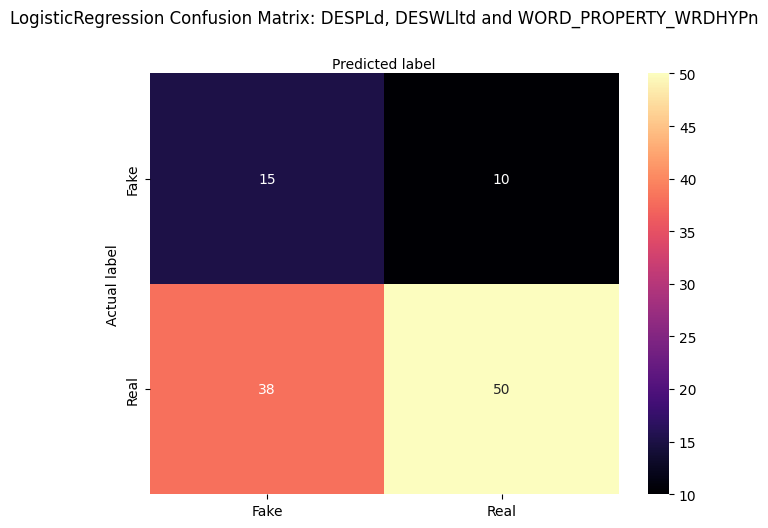

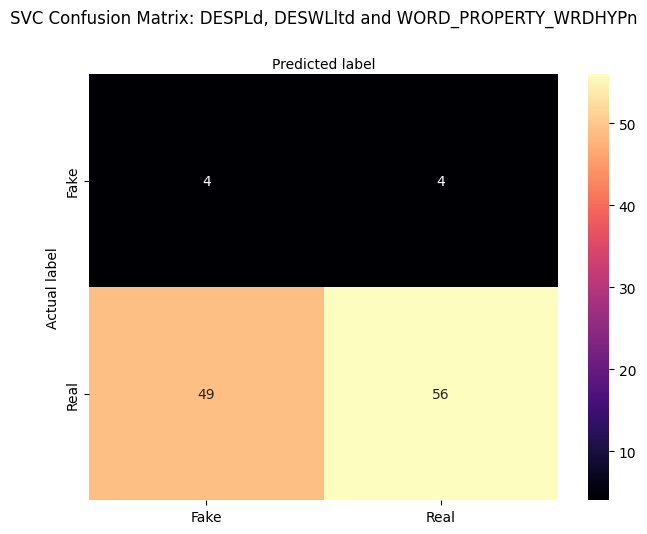

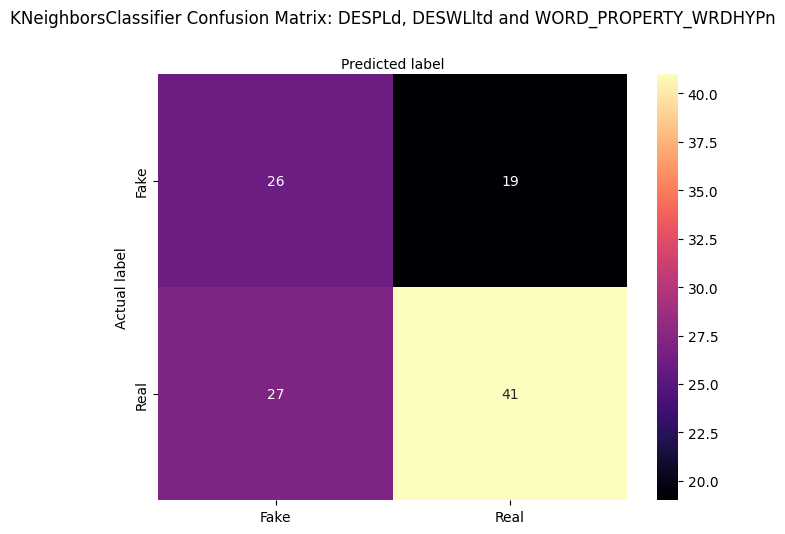

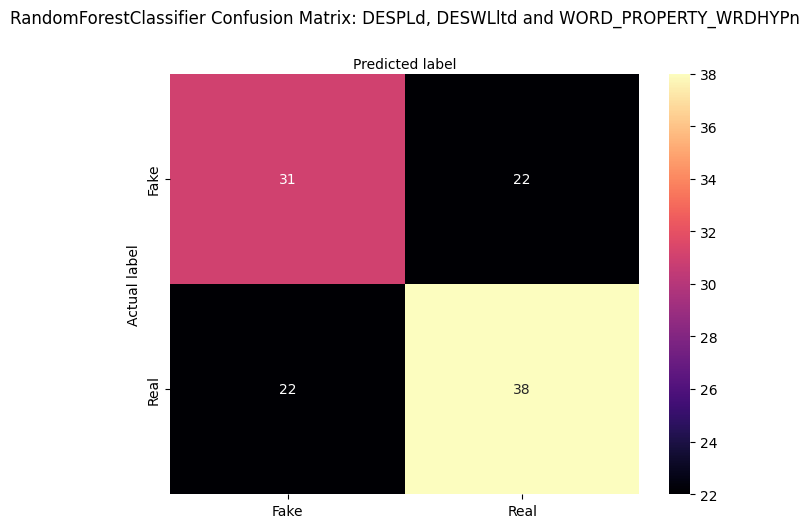

In [21]:
features = ['DESPLd',	'DESWLltd',	'WORD_PROPERTY_WRDHYPn']

models_all_features = magic(final_fts, features)

In [22]:
models_all_features


[{'name': 'DESPLd__DESWLltd__WORD_PROPERTY_WRDHYPn__LogisticRegression',
  'features': ['DESPLd', 'DESWLltd', 'WORD_PROPERTY_WRDHYPn'],
  'model': 'LogisticRegression',
  'accuracy': 0.5752212389380531,
  'precision_true': array([0.56818182]),
  'recall_true': array([0.83333333]),
  'f1_score_true': array([0.67567568]),
  'precision_false': array([0.6]),
  'recall_false': array([0.28301887]),
  'f1_score_false': array([0.38461538]),
  'cv_scores': array([0.56666667, 0.54444444, 0.55555556, 0.58888889, 0.54444444]),
  'mean_cv_accuracy': 0.5599999999999999,
  'confussion_matrix': array([[15, 10],
         [38, 50]], dtype=int64),
  'data_test_source': 'training dataset',
  'training_normalized_together': 'yes',
  'testing_normalized_together': 'yes, subset of training'},
 {'name': 'DESPLd__DESWLltd__WORD_PROPERTY_WRDHYPn__SVC',
  'features': ['DESPLd', 'DESWLltd', 'WORD_PROPERTY_WRDHYPn'],
  'model': 'SVC',
  'accuracy': 0.5309734513274337,
  'precision_true': array([0.53333333]),
  're

# Models excluding different features each time

DESWLltd and WORD_PROPERTY_WRDHYPn

Info: 2 features were passed at the fit step
:
DESWLltd
WORD_PROPERTY_WRDHYPn

 LogisticRegression 
 

OVERALL ACCURACY LogisticRegression : 57.5 %

              precision    recall  f1-score   support

        Fake       0.58      0.55      0.56        60
        Real       0.57      0.60      0.59        60

    accuracy                           0.57       120
   macro avg       0.58      0.57      0.57       120
weighted avg       0.58      0.57      0.57       120

CROSS VALIDATION

Cross validation accuracy LogisticRegression for each of the 5 iterations:
58.33 %
60.42 %
59.38 %
46.88 %
63.54 %

Cross validation mean accuracy for LogisticRegression: 57.71 %

-------------------------------------------------------------------------


 SVC 
 

OVERALL ACCURACY SVC : 50.0 %

              precision    recall  f1-score   support

        Fake       0.50      0.65      0.57        60
        Real       0.50      0.35      0.41        60

    accuracy                           0.50   

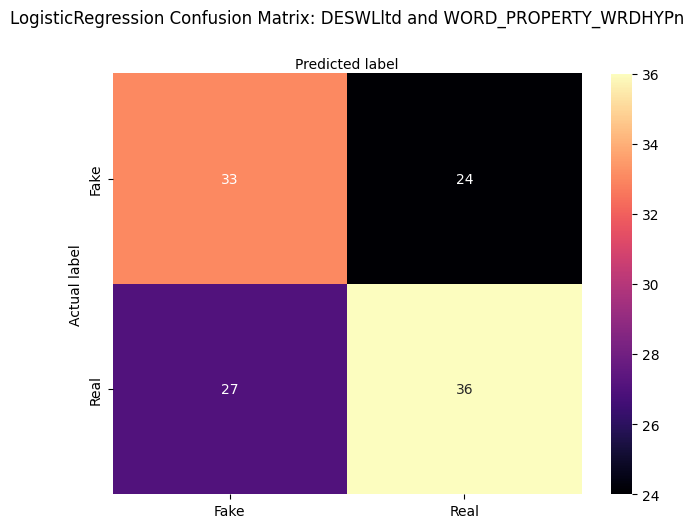

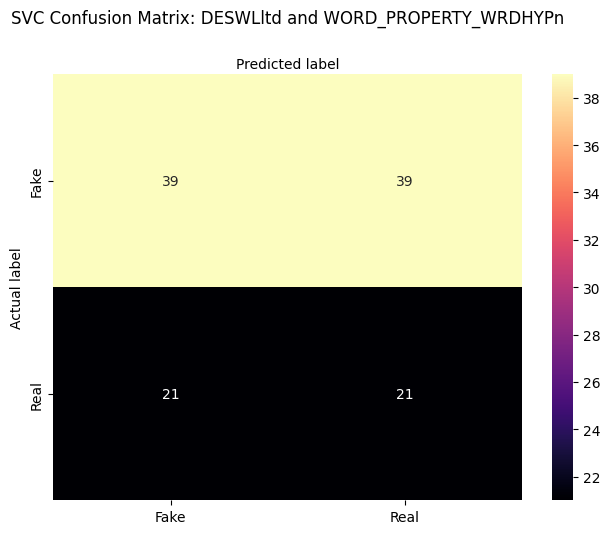

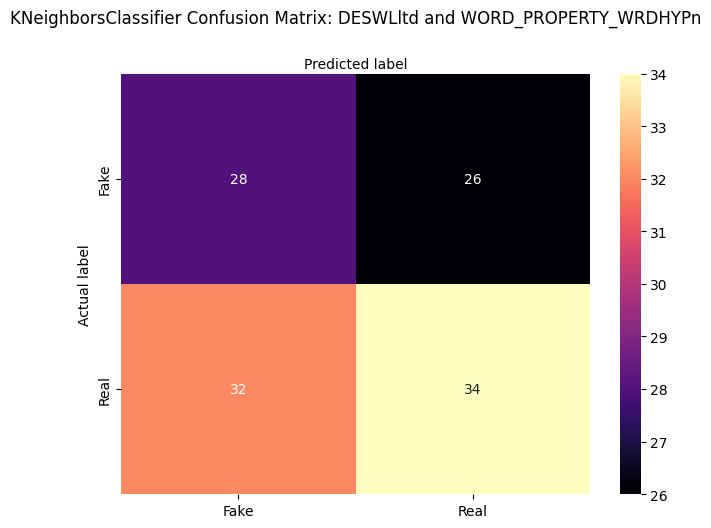

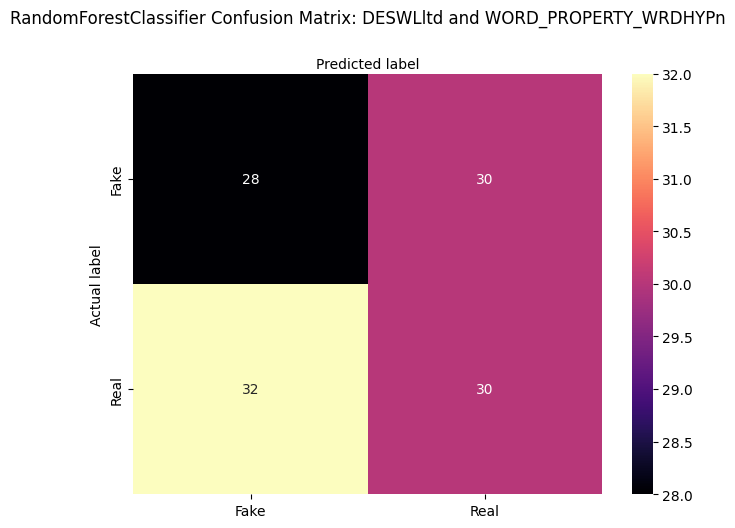

In [23]:
features = ['DESWLltd',	'WORD_PROPERTY_WRDHYPn']
models_DESWLltd_WORD_PROPERTY_WRDHYPn = magic(final_fts, features)

In [24]:
models_DESWLltd_WORD_PROPERTY_WRDHYPn

[{'name': 'DESWLltd__WORD_PROPERTY_WRDHYPn__LogisticRegression',
  'features': ['DESWLltd', 'WORD_PROPERTY_WRDHYPn'],
  'model': 'LogisticRegression',
  'accuracy': 0.575,
  'precision_true': array([0.57142857]),
  'recall_true': array([0.6]),
  'f1_score_true': array([0.58536585]),
  'precision_false': array([0.57894737]),
  'recall_false': array([0.55]),
  'f1_score_false': array([0.56410256]),
  'cv_scores': array([0.58333333, 0.60416667, 0.59375   , 0.46875   , 0.63541667]),
  'mean_cv_accuracy': 0.5770833333333333,
  'confussion_matrix': array([[33, 24],
         [27, 36]], dtype=int64),
  'data_test_source': 'training dataset',
  'training_normalized_together': 'yes',
  'testing_normalized_together': 'yes, subset of training'},
 {'name': 'DESWLltd__WORD_PROPERTY_WRDHYPn__SVC',
  'features': ['DESWLltd', 'WORD_PROPERTY_WRDHYPn'],
  'model': 'SVC',
  'accuracy': 0.5,
  'precision_true': array([0.5]),
  'recall_true': array([0.35]),
  'f1_score_true': array([0.41176471]),
  'precisi

DESPLd and	WORD_PROPERTY_WRDHYPn

Info: 2 features were passed at the fit step
:
DESPLd
WORD_PROPERTY_WRDHYPn

 LogisticRegression 
 

OVERALL ACCURACY LogisticRegression : 59.29 %

              precision    recall  f1-score   support

        Fake       0.63      0.32      0.42        53
        Real       0.58      0.83      0.68        60

    accuracy                           0.59       113
   macro avg       0.61      0.58      0.55       113
weighted avg       0.60      0.59      0.56       113

CROSS VALIDATION

Cross validation accuracy LogisticRegression for each of the 5 iterations:
56.67 %
52.22 %
55.56 %
60.0 %
56.67 %

Cross validation mean accuracy for LogisticRegression: 56.22 %

-------------------------------------------------------------------------


 SVC 
 

OVERALL ACCURACY SVC : 53.1 %

              precision    recall  f1-score   support

        Fake       0.50      0.02      0.04        53
        Real       0.53      0.98      0.69        60

    accuracy                           0.53     

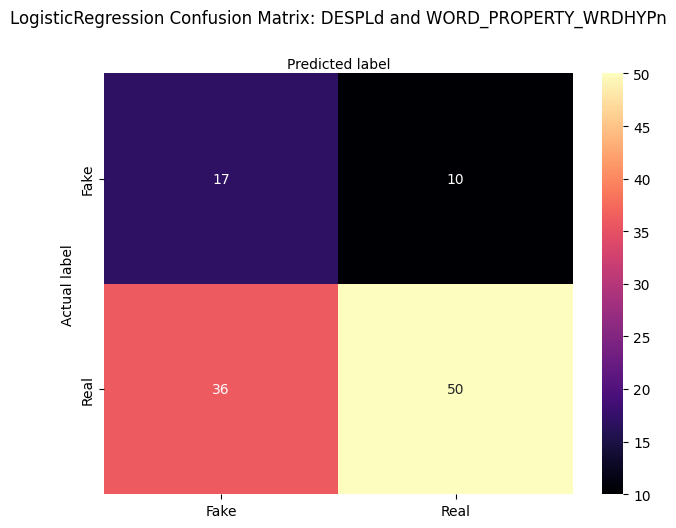

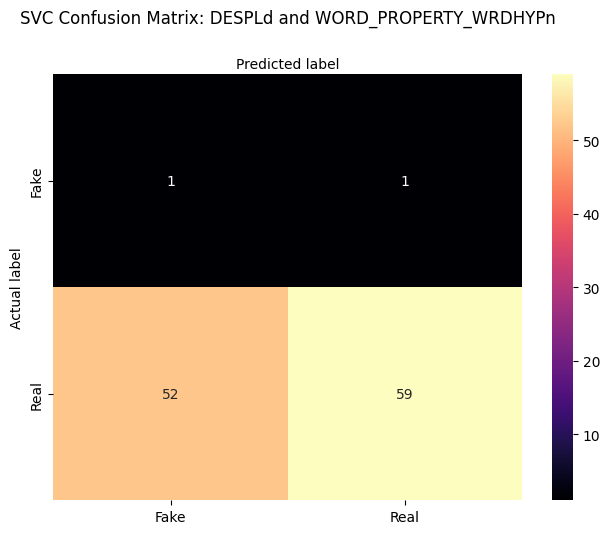

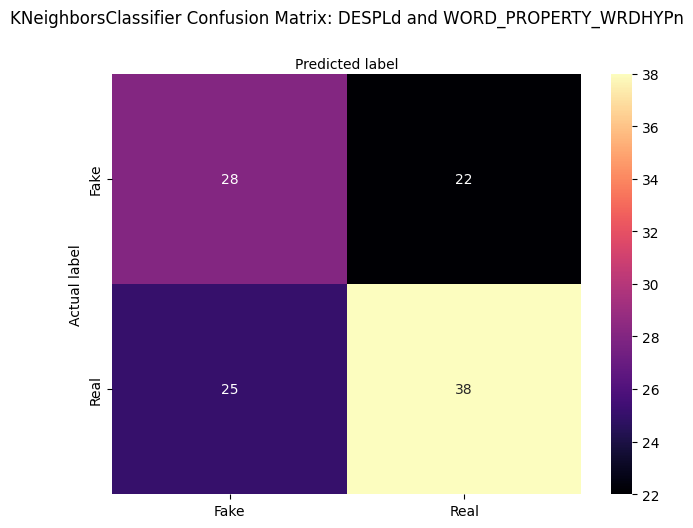

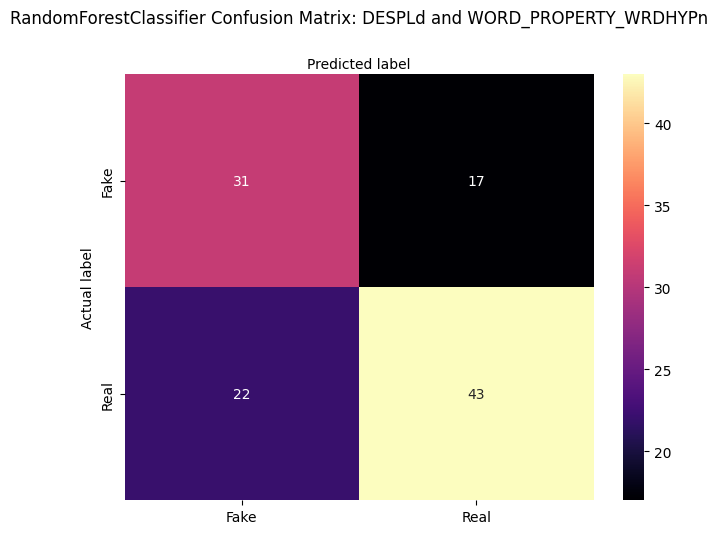

In [25]:
features = ['DESPLd',	'WORD_PROPERTY_WRDHYPn']
models_DESPLd_WORD_PROPERTY_WRDHYPn = magic(final_fts, features)

In [26]:
models_DESPLd_WORD_PROPERTY_WRDHYPn

[{'name': 'DESPLd__WORD_PROPERTY_WRDHYPn__LogisticRegression',
  'features': ['DESPLd', 'WORD_PROPERTY_WRDHYPn'],
  'model': 'LogisticRegression',
  'accuracy': 0.5929203539823009,
  'precision_true': array([0.58139535]),
  'recall_true': array([0.83333333]),
  'f1_score_true': array([0.68493151]),
  'precision_false': array([0.62962963]),
  'recall_false': array([0.32075472]),
  'f1_score_false': array([0.425]),
  'cv_scores': array([0.56666667, 0.52222222, 0.55555556, 0.6       , 0.56666667]),
  'mean_cv_accuracy': 0.5622222222222222,
  'confussion_matrix': array([[17, 10],
         [36, 50]], dtype=int64),
  'data_test_source': 'training dataset',
  'training_normalized_together': 'yes',
  'testing_normalized_together': 'yes, subset of training'},
 {'name': 'DESPLd__WORD_PROPERTY_WRDHYPn__SVC',
  'features': ['DESPLd', 'WORD_PROPERTY_WRDHYPn'],
  'model': 'SVC',
  'accuracy': 0.5309734513274337,
  'precision_true': array([0.53153153]),
  'recall_true': array([0.98333333]),
  'f1_sco

DESPLd and DESWLltd

Info: 2 features were passed at the fit step
:
DESWLltd
DESPLd

 LogisticRegression 
 

OVERALL ACCURACY LogisticRegression : 56.64 %

              precision    recall  f1-score   support

        Fake       0.59      0.25      0.35        53
        Real       0.56      0.85      0.68        60

    accuracy                           0.57       113
   macro avg       0.58      0.55      0.51       113
weighted avg       0.57      0.57      0.52       113

CROSS VALIDATION

Cross validation accuracy LogisticRegression for each of the 5 iterations:
57.78 %
54.44 %
55.56 %
58.89 %
54.44 %

Cross validation mean accuracy for LogisticRegression: 56.22 %

-------------------------------------------------------------------------


 SVC 
 

OVERALL ACCURACY SVC : 53.1 %

              precision    recall  f1-score   support

        Fake       0.50      0.08      0.13        53
        Real       0.53      0.93      0.68        60

    accuracy                           0.53       113
   mac

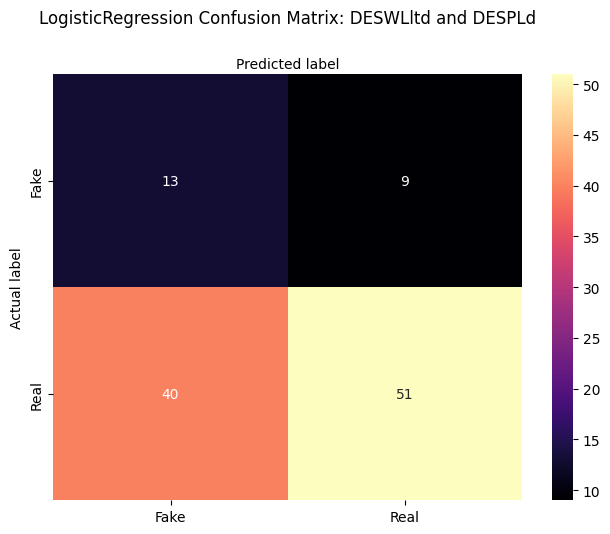

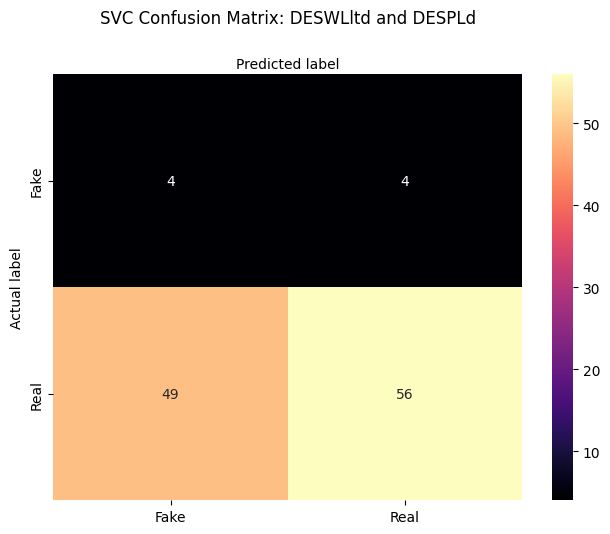

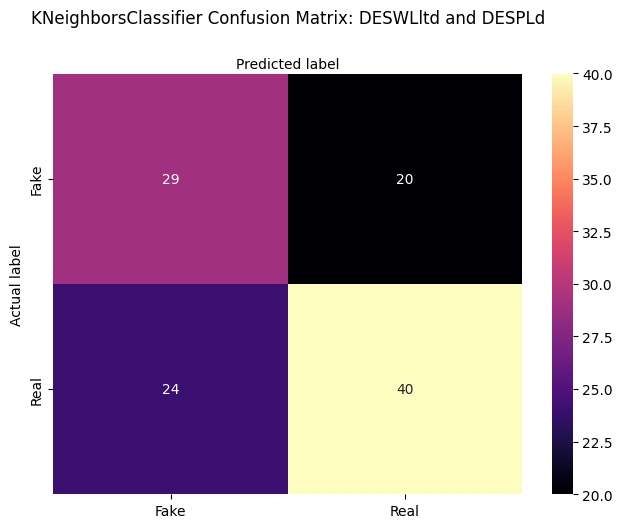

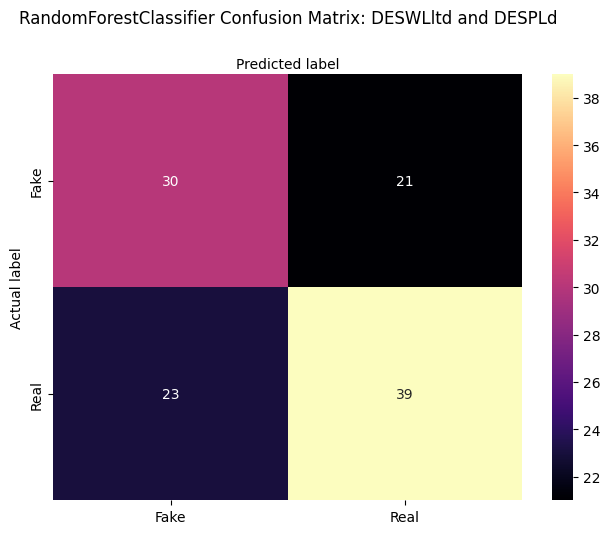

In [27]:
features = ['DESWLltd',	'DESPLd']
models_DESWLltd_DESWLltd = magic(final_fts, features)


In [28]:
models_DESWLltd_DESWLltd

[{'name': 'DESWLltd__DESPLd__LogisticRegression',
  'features': ['DESWLltd', 'DESPLd'],
  'model': 'LogisticRegression',
  'accuracy': 0.5663716814159292,
  'precision_true': array([0.56043956]),
  'recall_true': array([0.85]),
  'f1_score_true': array([0.67549669]),
  'precision_false': array([0.59090909]),
  'recall_false': array([0.24528302]),
  'f1_score_false': array([0.34666667]),
  'cv_scores': array([0.57777778, 0.54444444, 0.55555556, 0.58888889, 0.54444444]),
  'mean_cv_accuracy': 0.5622222222222222,
  'confussion_matrix': array([[13,  9],
         [40, 51]], dtype=int64),
  'data_test_source': 'training dataset',
  'training_normalized_together': 'yes',
  'testing_normalized_together': 'yes, subset of training'},
 {'name': 'DESWLltd__DESPLd__SVC',
  'features': ['DESWLltd', 'DESPLd'],
  'model': 'SVC',
  'accuracy': 0.5309734513274337,
  'precision_true': array([0.53333333]),
  'recall_true': array([0.93333333]),
  'f1_score_true': array([0.67878788]),
  'precision_false': a

# Models using only DESWLltd, the unbalanced feature

DESWLltd

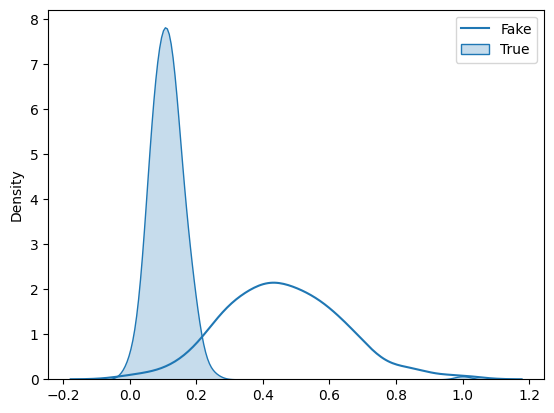




Info: 1 features were passed at the fit step
:
DESWLltd

 LogisticRegression 
 

OVERALL ACCURACY LogisticRegression : 57.5 %

              precision    recall  f1-score   support

        Fake       0.57      0.58      0.58        60
        Real       0.58      0.57      0.57        60

    accuracy                           0.57       120
   macro avg       0.58      0.57      0.57       120
weighted avg       0.58      0.57      0.57       120

CROSS VALIDATION

Cross validation accuracy LogisticRegression for each of the 5 iterations:
55.21 %
63.54 %
52.08 %
57.29 %
59.38 %

Cross validation mean accuracy for LogisticRegression: 57.5 %

-------------------------------------------------------------------------


 SVC 
 

OVERALL ACCURACY SVC : 50.0 %

              precision    recall  f1-score   support

        Fake       0.50      1.00      0.67        60
        Real       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,


 RandomForestClassifier 
 

OVERALL ACCURACY RandomForestClassifier : 55.0 %

              precision    recall  f1-score   support

        Fake       0.56      0.50      0.53        60
        Real       0.55      0.60      0.57        60

    accuracy                           0.55       120
   macro avg       0.55      0.55      0.55       120
weighted avg       0.55      0.55      0.55       120

CROSS VALIDATION

Cross validation accuracy RandomForestClassifier for each of the 5 iterations:
41.67 %
46.88 %
47.92 %
48.96 %
54.17 %

Cross validation mean accuracy for RandomForestClassifier: 47.92 %

-------------------------------------------------------------------------



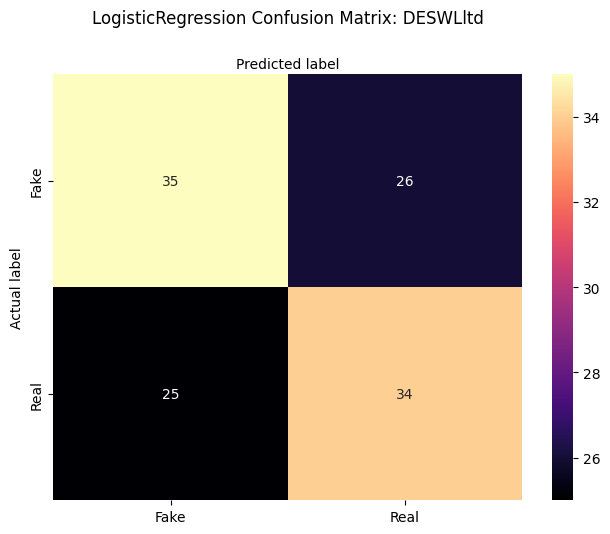

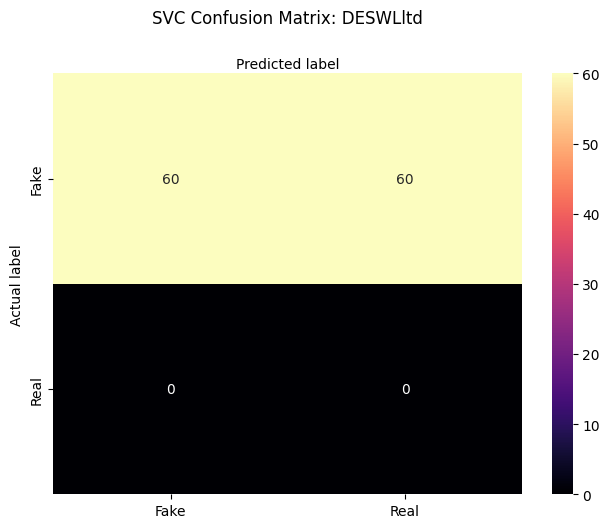

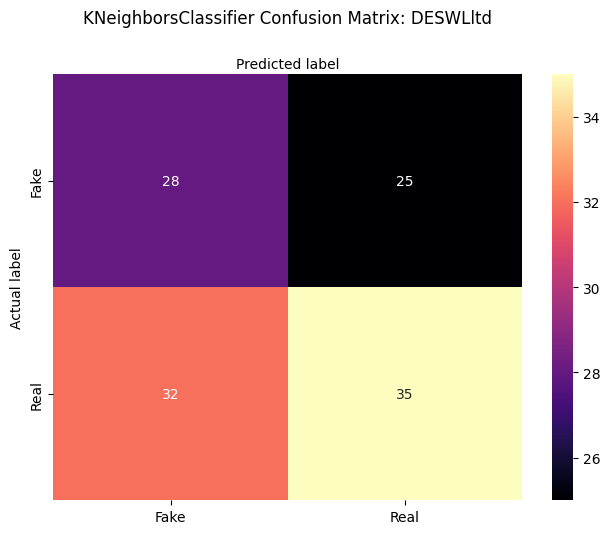

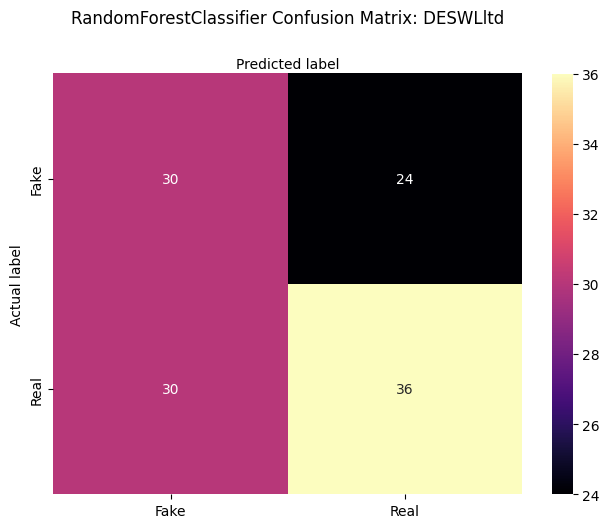

In [29]:
features = ['DESWLltd']
models_DESWLltd = magic(final_fts, features)

In [30]:
models_DESWLltd

[{'name': 'DESWLltd__LogisticRegression',
  'features': ['DESWLltd'],
  'model': 'LogisticRegression',
  'accuracy': 0.575,
  'precision_true': array([0.57627119]),
  'recall_true': array([0.56666667]),
  'f1_score_true': array([0.57142857]),
  'precision_false': array([0.57377049]),
  'recall_false': array([0.58333333]),
  'f1_score_false': array([0.5785124]),
  'cv_scores': array([0.55208333, 0.63541667, 0.52083333, 0.57291667, 0.59375   ]),
  'mean_cv_accuracy': 0.575,
  'confussion_matrix': array([[35, 26],
         [25, 34]], dtype=int64),
  'data_test_source': 'training dataset',
  'training_normalized_together': 'yes',
  'testing_normalized_together': 'yes, subset of training'},
 {'name': 'DESWLltd__SVC',
  'features': ['DESWLltd'],
  'model': 'SVC',
  'accuracy': 0.5,
  'precision_true': array([0.]),
  'recall_true': array([0.]),
  'f1_score_true': array([0.]),
  'precision_false': array([0.5]),
  'recall_false': array([1.]),
  'f1_score_false': array([0.66666667]),
  'cv_score